In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(data.head(3))


         Date  Close/Last    Volume    Open    High     Low
0  09/12/2024      559.09  51892740  555.01  559.40  552.74
1  09/11/2024      554.42  75248610  548.70  555.36  539.96
2  09/10/2024      548.79  36394580  548.36  549.15  543.38


In [3]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['intraday_up_MINUS_intraday_down_ratio'] = data['High_minus_Open'] - data['Open_minus_Low']
data['intraday_change'] = (data['Close/Last'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)


data['intraday_range'] = (data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()

# Create lagged features comparing today's open to these moving averages
data['lag_5'] = (data['Open'] > data['MA_5']).astype(int)
data['lag_14'] = (data['Open'] > data['MA_14']).astype(int)
data['lag_50'] = (data['Open'] > data['MA_50']).astype(int)



data['MA_Crossover_Signal_5_14'] = (data['MA_5'] > data['MA_14']).astype(int)

# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_5']).astype(int)



In [4]:
print(data.columns)

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low',
       'High_minus_Open', 'Open_minus_Low',
       'intraday_up_MINUS_intraday_down_ratio', 'intraday_change',
       'day_change', 'intraday_range', 'opening_gaps',
       'net_Intraday_Movement_Around_Open', 'MA_5', 'MA_14', 'MA_50', 'lag_5',
       'lag_14', 'lag_50', 'MA_Crossover_Signal_5_14',
       'yesterday_close_above_MA_5'],
      dtype='object')


In [5]:
data['OBV'] = 0

# Initialize the first value of OBV
data.loc[0, 'OBV'] = data.loc[0, 'Volume']

# Calculate OBV
for i in range(1, len(data)):
    if data.loc[i, 'Close/Last'] > data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] + data.loc[i, 'Volume']
    elif data.loc[i, 'Close/Last'] < data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] - data.loc[i, 'Volume']
    else:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV']

# Display the first few rows to check the new column
print(data.head(1))
print(''' Creates the OBV''')

         Date  Close/Last    Volume    Open   High     Low  High_minus_Open  \
0  09/12/2024      559.09  51892740  555.01  559.4  552.74         0.007881   

   Open_minus_Low  intraday_up_MINUS_intraday_down_ratio  intraday_change  \
0        0.004075                               0.003806         0.007324   

   ...  net_Intraday_Movement_Around_Open  MA_5  MA_14  MA_50  lag_5  lag_14  \
0  ...                           0.003806   NaN    NaN    NaN      0       0   

   lag_50  MA_Crossover_Signal_5_14  yesterday_close_above_MA_5       OBV  
0       0                         0                           0  51892740  

[1 rows x 23 columns]
 Creates the OBV


In [6]:
# "OBV_PCT_CHANGE IS ON A DIFFERENT SCALE AS THE "SPY_PCT_CHANGE"  BECAUSE OBV IS A CUMULATIVE FIGURE AND THE SPY_PCT_CHANGE IS NOT. MAKING THE WHOLE THING...
# ...NONSENSICAL... THE PERCENTAGE CHANGES OF THE OBV WILL BECOME MINISCULE AS EACH DAY'S VOLUME BECOMES INSUBSTANTIAL WHEN THE OBV SNOWBALLS TO A 
# HIGH VALUE OR LOW VALUE
# Use z-value of the spy change or the volume change

data['OBV_pct_change'] = data['OBV'].pct_change() * 100
data['SPY_pct_change'] = data['day_change'] * 100
data['OBV_SPY_pct_diff'] = data['OBV_pct_change'] - data['SPY_pct_change']

def calculate_obv_spy_metric_backward(data, initial_window_size=5, threshold=15):
    data['OBV_SPY_metric'] = np.nan  # Initialize the new independent variable column
    data['OBV_SPY_window_length'] = np.nan  # Initialize column for window length
    data['Original_Index'] = np.nan  # Initialize column for index
    
    for i in range(len(data) - initial_window_size):
        max_diff = 0
        j = initial_window_size
        
        while i - j >= 0:
            # Calculate rolling sum of differences (backward-looking)
            current_window = data['OBV_SPY_pct_diff'].iloc[i-j:i].sum()
            abs_current_diff = abs(current_window)
            
            if abs_current_diff > max_diff:
                max_diff = abs(current_window)
            
            retracement = ((max_diff - abs_current_diff) / max_diff) * 100 if max_diff != 0 else 0
            
            if retracement >= threshold:
                break
            
            j += 1
        
        # After the loop, assign the max difference and window length
        data.at[i, 'OBV_SPY_metric'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j
        data.at[i, 'Original_Index'] = i  # Assign the index value
    
    return data

# Apply the function to the DataFrame
data = calculate_obv_spy_metric_backward(data)

# Drop rows with NaN values in OBV_SPY_metric
data.dropna(subset=['OBV_SPY_metric'], inplace=True)

print(data[['Original_Index', 'Date', 'OBV_pct_change', 'SPY_pct_change', 'OBV_SPY_pct_diff', 'OBV_SPY_metric', 'OBV_SPY_window_length']].head(2))
print('''OBV_SPY_metric is the cumulative percentage change between the OBV and SPY since it last had a 15% retracement, OBV_SPY_window_length is the length of the window
    in days, and Index is the original index.''')
print(" as it's currently coded it will stop when teh threshold is met... not somethign that can be graphed")


   Original_Index        Date  OBV_pct_change  SPY_pct_change  \
0             0.0  09/12/2024             NaN             NaN   
1             1.0  09/11/2024     -145.007972       -0.835286   

   OBV_SPY_pct_diff  OBV_SPY_metric  OBV_SPY_window_length  
0               NaN             0.0                    5.0  
1       -144.172686             0.0                    5.0  
OBV_SPY_metric is the cumulative percentage change between the OBV and SPY since it last had a 15% retracement, OBV_SPY_window_length is the length of the window
    in days, and Index is the original index.
 as it's currently coded it will stop when teh threshold is met... not somethign that can be graphed


In [7]:
# THIS ONE USES THE THE MOVING AVERAGE OF THE OBV... THIS WAY THE PERCENTAGE CHANGE IN THE OBV DOESN'T BECOME TOO SMALL 

def calculate_adjusted_obv_metric(data, initial_window_size=5, threshold=15, volume_window=20):
    # Calculate daily OBV deltas (volume × price sign)
    data['OBV_delta'] = np.where(data['day_change'] > 0, data['Volume'],
                          np.where(data['day_change'] < 0, -data['Volume'], 0))

    # Rolling average volume (centered or trailing)
    data['Rolling_Avg_Vol'] = data['Volume'].rolling(window=volume_window, min_periods=1).mean()

    # OBV move factor: delta OBV / rolling avg volume
    data['OBV_move_factor'] = data['OBV_delta'] / data['Rolling_Avg_Vol']

    # SPY percent change
    data['SPY_pct_change'] = data['day_change'] * 100

    # Difference between OBV move factor and SPY % change
    data['OBV_SPY_diff'] = data['OBV_move_factor'] - data['SPY_pct_change']

    # Initialize result columns
    data['OBV_SPY_metric'] = np.nan
    data['OBV_SPY_window_length'] = np.nan
    data['Original_Index'] = np.nan

    # Main loop
    for i in range(len(data) - initial_window_size):
        max_diff = 0
        j = initial_window_size

        while i - j >= 0:
            current_window = data['OBV_SPY_diff'].iloc[i-j:i].sum()
            abs_current_diff = abs(current_window)

            if abs_current_diff > max_diff:
                max_diff = abs_current_diff

            retracement = ((max_diff - abs_current_diff) / max_diff) * 100 if max_diff != 0 else 0

            if retracement >= threshold:
                break

            j += 1

        data.at[i, 'OBV_SPY_metric'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j
        data.at[i, 'Original_Index'] = i

    return data

# Example usage:
# data = calculate_adjusted_obv_metric(data, initial_window_size=5, threshold=15, volume_window=20)


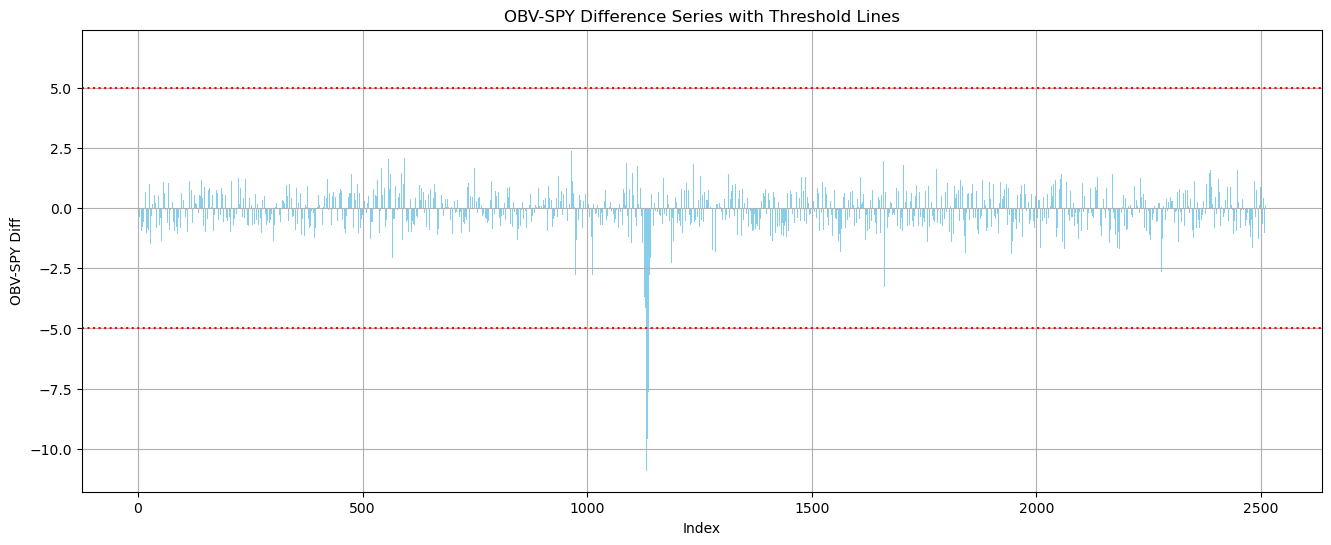

In [8]:
def calculate_obv_spy_diff_series(data, volume_window=20):
    # Calculate daily OBV deltas (volume × price sign)
    data['OBV_delta'] = np.where(data['day_change'] > 0, data['Volume'],
                          np.where(data['day_change'] < 0, -data['Volume'], 0))

    # Rolling average volume
    data['Rolling_Avg_Vol'] = data['Volume'].rolling(window=volume_window, min_periods=1).mean()

    # OBV move factor: delta OBV / rolling avg volume
    data['OBV_move_factor'] = data['OBV_delta'] / data['Rolling_Avg_Vol']

    # SPY percent change
    data['SPY_pct_change'] = data['day_change'] * 100

    # Difference between OBV move factor and SPY % change
    data['OBV_SPY_diff'] = data['OBV_move_factor'] - data['SPY_pct_change']

    return data

# Apply it
data = calculate_obv_spy_diff_series(data, volume_window=20)

# Plotting
plt.figure(figsize=(16,6))
plt.bar(data.index, data['OBV_SPY_diff'], color='skyblue')

# Add red horizontal threshold lines
threshold = 5
plt.axhline(y=threshold, color='red', linestyle='dotted', linewidth=1.5)
plt.axhline(y=-threshold, color='red', linestyle='dotted', linewidth=1.5)

plt.title('OBV-SPY Difference Series with Threshold Lines')
plt.xlabel('Index')
plt.ylabel('OBV-SPY Diff')
plt.grid(True)
plt.show()


In [17]:
def calculate_obv_spy_diff_static_zscore(data):
    # Calculate daily OBV deltas (volume × price sign)
    data['OBV_delta'] = np.where(data['day_change'] > 0, data['Volume'],
                          np.where(data['day_change'] < 0, -data['Volume'], 0))

    # Global mean and std dev for OBV delta
    obv_mean = data['OBV_delta'].mean()
    obv_std  = data['OBV_delta'].std()

    # OBV move factor as z-score normalized delta
    data['OBV_move_z'] = (data['OBV_delta'] - obv_mean) / obv_std

    # SPY percent change
    data['SPY_pct_change'] = data['day_change'] * 100

    # Global mean and std dev for SPY % change
    spy_mean = data['SPY_pct_change'].mean()
    spy_std  = data['SPY_pct_change'].std()

    # SPY z-score of percent change
    data['SPY_pct_z'] = (data['SPY_pct_change'] - spy_mean) / spy_std

    # Difference between OBV move z-score and SPY move z-score
    data['OBV_SPY_diff_z'] = data['OBV_move_z'] - data['SPY_pct_z']

    return data

# Apply it
data = calculate_obv_spy_diff_static_zscore(data)


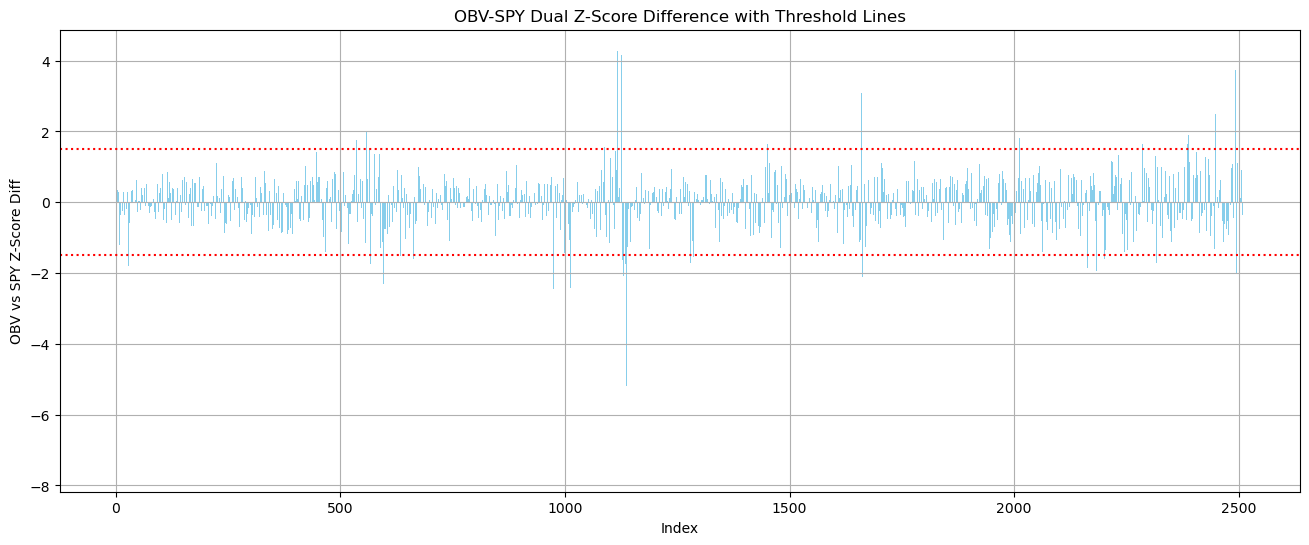

In [18]:
plt.figure(figsize=(16,6))
plt.bar(data.index, data['OBV_SPY_diff_z'], color='skyblue')
plt.axhline(y=1.5, color='red', linestyle='dotted', linewidth=1.5)
plt.axhline(y=-1.5, color='red', linestyle='dotted', linewidth=1.5)
plt.title('OBV-SPY Dual Z-Score Difference with Threshold Lines')
plt.xlabel('Index')
plt.ylabel('OBV vs SPY Z-Score Diff')
plt.grid(True)
plt.show()
